In [7]:
!spacy download en_core_web_md

import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score

In [3]:
df = pd.read_csv("data/intent-classification-training-data.csv").loc[:,["Question","Large Category"]]
display(df.sample(5))
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

,Question,Large Category
152,How do wildfires start naturally without light...,Fire Ecology
166,Will California wildfires merge into massive i...,Fire Ecology
350,How can I donate,Fire Recovery
128,What can California do to stop the wildfires i...,Fire Ecology
411,How to become a volunteer firefighter?,Getting Involved


In [21]:
class TextVectorizer(TransformerMixin):
    
    def transform(self, X, **transform_params):
        nlp = spacy.load(r'language_model\en_core_web_md-3.0.0\en_core_web_md\en_core_web_md-3.0.0')
        new_X = np.zeros((len(X), nlp.vocab.vectors_length))
        # Iterate over the sentences
        for idx, sentence in enumerate(X):
            # Pass each sentence to the nlp object to create a document
            doc = nlp(sentence)
            # Save the document's .vector attribute to the corresponding row in     
            # X
            new_X[idx, :] = doc.vector
        return new_X
    
    def fit(self, X, y=None, **fit_params):
        return self

In [22]:
pipe = Pipeline([("Spacy_Vectorizer", TextVectorizer()),
                 ('Classifier',  LogisticRegression(solver='lbfgs', max_iter=7600))])

In [23]:
pipe.fit(df_train["Question"], df_train["Large Category"])

Pipeline(steps=[('Spacy_Vectorizer',
                 <__main__.TextVectorizer object at 0x000002135597FD00>),
                ('Classifier', LogisticRegression(max_iter=7600))])

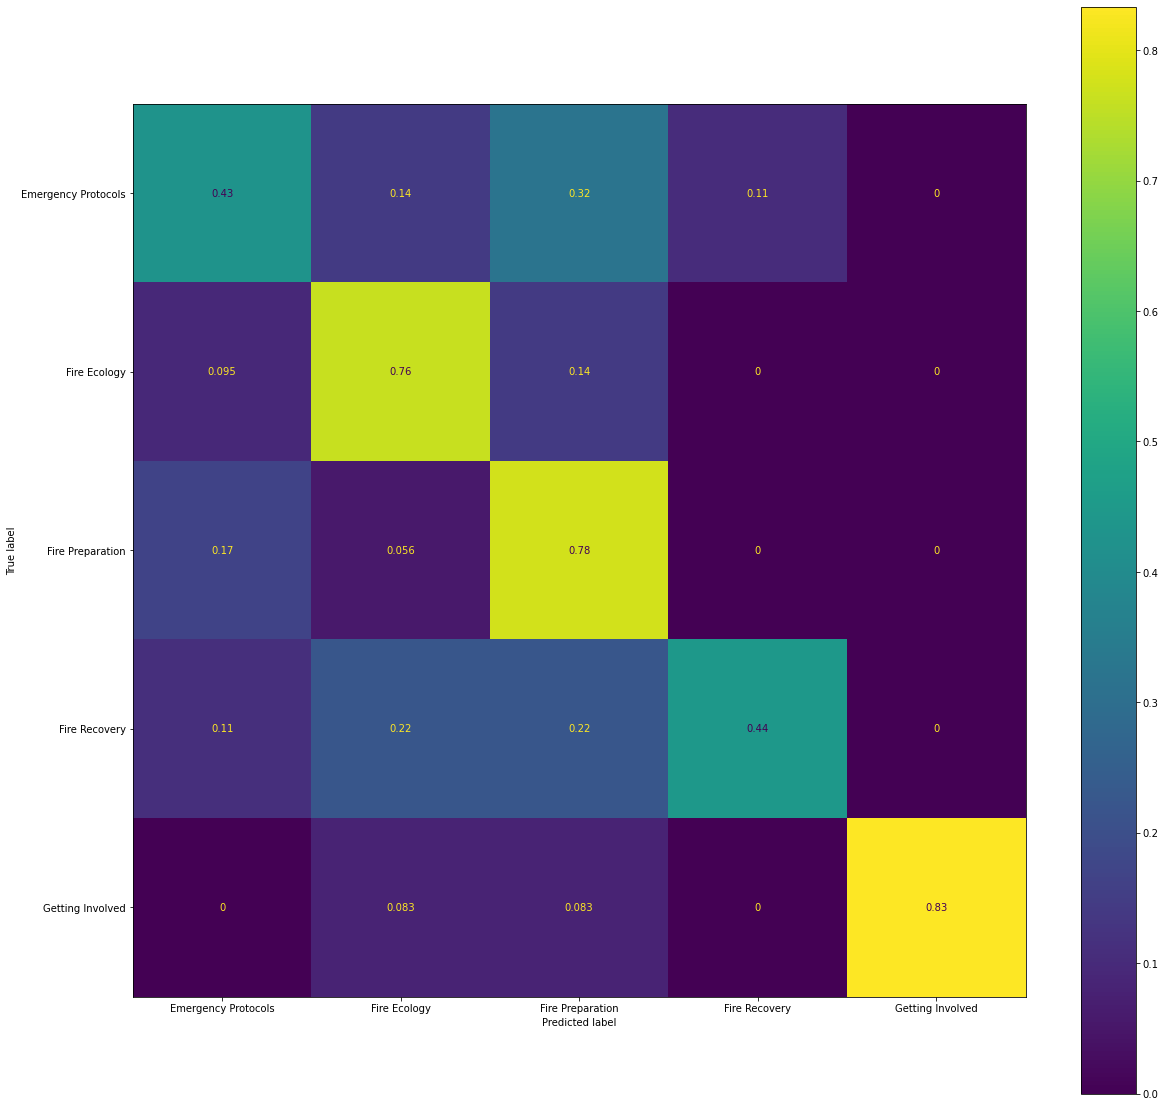

In [24]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(pipe, df_test.Question, df_test["Large Category"], normalize='true', ax=ax);

In [25]:
scores = cross_val_score(pipe, X=df_train.Question, y=df_train["Large Category"], cv=5)

In [26]:
scores

array([0.81428571, 0.68571429, 0.77142857, 0.7       , 0.68115942])